In [1]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"

# Transfer Learning with TensorFlow Part 1: Feature Extraction

We've built a bunch of convolutional neural networks from scratch and they all seem to be learning, however, there is still plenty of room for improvement.

To improve our model(s), we could spend a while trying different configurations, adding more layers, changing the learning rate, adjusting the number of neurons per layer and more.

However, doing this is very time consuming.

Luckily, there's a technique we can use to save time.

It's called **transfer learning**, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has **already learned** patterns on similar data to our own. This often results in achieving great results with less custom data.

What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as [ImageNet](http://www.image-net.org/) (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

## What we're going to cover

We're going to go through the following with TensorFlow:

- Introduce transfer learning (a way to beat all of our old self-built models)
- Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
- Build a transfer learning feature extraction model using TensorFlow Hub
- Introduce the TensorBoard callback to track model training results
- Compare model results using TensorBoard.

## Transfer leanring with TensorFlow Hub: Getting great results with 10% of the data


For many of the problems you'll want to use deep learning for, chances are, a working model already exists.

And the good news is, you can access many of them on TensorFlow Hub.

[TensorFlow Hub](https://tfhub.dev/) is a repository for existing model components. It makes it so you can import and use a fully trained model with as little as a URL.

**Transfer learning often allows you to get great results with less data.**

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png)
*What we're working towards building. Taking a pre-trained model and adding our own custom layers on top, extracting all of the underlying patterns learned on another dataset our own images.*

In [2]:
# To Download Files/Datasets from Links Directly.
!pip install wget --user 

In [3]:
import wget

url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
wget.download(url)

'10_food_classes_10_percent.zip'

In [4]:
# Unziping The Zip File / Dataset Downloaded from Above Step:
import zipfile
file = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
file.extractall()
file.close()

In [5]:
os.listdir() # Listing Files in Current Directory Check if The Download and
             # Unzipping Worked Successfully

['.anaconda',
 '.conda',
 '.condarc',
 '.continuum',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.keras',
 '.matplotlib',
 '.tobii',
 '04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb',
 '1) Tensorflow Fundamentals.ipynb',
 '10_food_classes_10_percent',
 '10_food_classes_10_percent.zip',
 '2) Regression With Neural Networks Using Tensorflow.ipynb',
 '3) Classification With Neural Networks Using Tensorflow.ipynb',
 '4) Convolutional Neural Networks and Computer Vision Using  Tensorflow.ipynb',
 '5) Transfer Learning Using Tensorflow Part 1 - Feature Extraction.ipynb',
 'anaconda3',
 'ansel',
 'AppData',
 'Application Data',
 'chckncur (1).jpg',
 'chckncur (2).jpg',
 'Contacts',
 'Cookies',
 'Desktop',
 'Documents',
 'Downloads',
 'Favorites',
 'food_10_classes',
 'frdrce.jpg',
 'iccrm (1).jpg',
 'iccrm (2).jpg',
 'insurance.csv',
 'Links',
 'Local Settings',
 'Music',
 'My Documents',
 'NetHood',
 'NTUSER.DAT',
 'ntuser.dat.LOG1',
 'ntuser.dat.LOG2',
 'NTUSER.DA

In [6]:
# Checking Number of Folders and Files in Dataset:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

Notice how each of the training directories now has 75 images rather than 750 images. This is key to demonstrating how well transfer learning can perform with less labelled images.

The test directories still have the same amount of images. This means we'll be training on less data but evaluating our models on the same amount of test data.

## Creating data loaders (preparing the data)

Now we've downloaded the data, let's use the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class along with the `flow_from_directory` method to load in our images.

In [7]:
# Setup to Load and Pre-Process The Data:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_shape = (224,224) # Target Image Shape that we want our Images to be in.
batch_size = 32 # Batch Size to feed images in Model

# Training Data Directory Path:
train_dir = "10_food_classes_10_percent\\train\\"

# Testing Data Directory Path:
test_dir = "10_food_classes_10_percent\\test\\"

# Preparing Data Generators:
train_datagen = ImageDataGenerator(rescale= 1/255)
test_datagen = ImageDataGenerator(rescale= 1/255)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                    target_size= image_shape,
                                                    batch_size= batch_size,
                                                    class_mode= "categorical")

print("testing Images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size= image_shape,
                                            batch_size= batch_size,
                                            class_mode= "categorical")


Training Images:
Found 750 images belonging to 10 classes.
testing Images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is **callbacks**.

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
* [**Experiment tracking with TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on [TensorBoard](https://www.tensorflow.org/tensorboard) (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

The TensorBoard callback can be accessed using [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard). 

Its main functionality is saving a model's training performance metrics to a specified `log_dir`.

By default, logs are recorded every epoch using the `update_freq='epoch'` parameter. This is a good default since tracking model performance too often can slow down model training.

To track our modelling experiments using TensorBoard, let's create a function which creates a TensorBoard callback for us.

We create a function for creating a TensorBoard callback because as we'll see later on, each model needs its own TensorBoard callback instance (so the function will create a new one each time it's run).

In [31]:
# Creating A Function for Tensorboard Callback:

import tensorflow as tf
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    
    log_dir = dir_name + "\\" + experiment_name + "\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir = log_dir)
    print(f"Saving TensorBoard Log Files to {log_dir}\n")
    
    return tensorboard_callback

Because we're likely to run multiple experiments, it's a good idea to be able to track them in some way.

In our case, our function saves a model's performance logs to a directory named `[dir_name]/[experiment_name]/[current_timestamp]`, where:
* `dir_name` is the overall logs directory
* `experiment_name` is the particular experiment
* `current_timestamp` is the time the experiment started based on Python's [`datetime.datetime().now()`](https://docs.python.org/3/library/datetime.html#datetime.datetime.now)

Depending on your use case, the above experimenting tracking naming method may work or you might require something more specific. The good news is, the TensorBoard callback makes it easy to track modelling logs as long as you specify where to track them. So you can get as creative as you like with how you name your experiments, just make sure you can understand them.

## Creating models using TensorFlow Hub (Now Integrated with Kaggle)

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from [TensorFlow Hub](https://www.kaggle.com/models?tfhub-redirect=true).

In fact, we're going to use two models from TensorFlow Hub:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) -  a state of the art computer vision model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.

State of the art means that at some point, both of these models have achieved the lowest error rate on [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks.

How to you find these models on TensorFlow Hub?

Here are the steps I took:

1. Go to [tfhub.dev](https://www.kaggle.com/models?tfhub-redirect=true).
2. Choose your problem domain, e.g. "Image" (we're using food images).
3. Select your TF version, which in our case is TF2.
4. Remove all "Problem domanin" filters except for the problem you're working on. 
5. The models listed are all models which could potentially be used for your problem.

> 🤔 **Question:** *I see many options for image classification models, how do I know which is best?*

You can see a list of state of the art models on [paperswithcode.com](https://www.paperswithcode.com), a resource for collecting the latest in deep learning paper results which have code implementations for the findings they report.

Since we're working with images, our target are the [models which perform best on ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet).

You'll probably find not all of the model architectures listed on paperswithcode appear on TensorFlow Hub. And this is okay, we can still use what's available.

To find our models, let's narrow down our search using the Architecture tab.

6. Select the Architecture tab on TensorFlow Hub and you'll see a dropdown menu of architecture names appear. The rule of thumb here is generally, names with larger numbers means better performing models. For example, EfficientNetB4 performs better than EfficientNetB0. However, the tradeoff with larger numbers can mean they take longer to compute. 
7. [Select EfficientNetB0] (https://www.kaggle.com/models/google/efficientnet-v2/tensorFlow2/)
8. Clicking the one titled "[efficientnet/b0/feature-vector](https://www.kaggle.com/models/tensorflow/efficientnet/tensorFlow2/b0-feature-vector/1?tfhub-redirect=true)" brings us to a page with a button that have code sippet of how we can use the model. Copy Model's URL from the snippet.
  * Copying the URL should give you something like this: https://www.kaggle.com/models/tensorflow/efficientnet/tensorFlow2/b0-feature-vector/1?tfhub-redirect=true

**Question:** *I thought we were doing image classification, why do we choose feature vector and not classification?*

Great observation. This is where the differnet types of transfer learning come into play, as is, feature extraction and fine-tuning.

1. **"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes. 

  * For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class). 

    * This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with `"/classification"` in their name on TensorFlow Hub provide this kind of functionality.

2. **Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem. 

  * For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that **only the top few layers become trainable, the rest remain frozen**. 

    * This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. **Fine-tuning transfer learning** is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem. 

    * This usually means training **some, many or all** of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (**feature extraction**).

After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further **fine-tune** the pretrained model.

> 🤔 **Question:** *Why train only the top 2-3 layers in feature extraction?*

The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png)
*The different kinds of transfer learning. An original model, a feature extraction model (only top 2-3 layers change) and a fine-tuning model (many or all of original model get changed).*

Now we'll get the feature vector URLs of two common computer vision architectures, [EfficientNetB0 (2019)](https://www.kaggle.com/models/tensorflow/efficientnet/tensorFlow2/b0-feature-vector/1?tfhub-redirect=true) and [ResNetV250 (2016)](https://www.kaggle.com/models/google/resnet-v2/tensorFlow2/50-feature-vector/1?tfhub-redirect=true) from TensorFlow Hub using the steps above.

We're getting both of these because we're going to compare them to see which performs better on our data.

Comparing different model architecture performance on the same data is a very common practice. The simple reason is because you want to know which model performs best for your problem.

In [9]:
 # To Load Pre-Trained Models from Tensorflow Hub
!pip install tensorflow_hub --user

In [33]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [11]:
# Resnet V250 Feature Vector:

resnet_url = "https://kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/1"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

These URLs link to a saved pretrained model on TensorFlow Hub.

When we use them in our model, the model will automatically be downloaded for us to use.

To do this, we can use the [`KerasLayer()`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) model inside the TensorFlow hub library.

Since we're going to be comparing two models, to save ourselves code, we'll create a function `create_model()`. This function will take a model's TensorFlow Hub URL, instatiate a Keras Sequential model with the appropriate number of output layers and return the model.

In [12]:
def create_model(model_url, num_classes= 10):
    
    """
    Takes a Tensorflow Hub URL and Creates a Keras Sequential Model with It.
    
    ARGS:
    model_url (str): A Tensorflow Hub Feature Extraction URL.
    num_class (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.
      
    Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
    
    """
    
    # Download Pre-Trained Model from Tensorflow Hub and Save it as a
    # Keras Layer
    feature_extractor_layer = hub.KerasLayer(handle= model_url,
                                            trainable= False,
                                            input_shape= (224,224,3)) # Freeze already learned Patterns / Weights
                                            
    
    # Creating Our Own Model
    model = Sequential()
    model.add(feature_extractor_layer)
    model.add(Dense(10, activation= "softmax"))
    
    return model

## Creating and Testing Resnetv250 Feature Extraction Model:

In [28]:
# Creating Resnet Model:
resnet_model = create_model(resnet_url, 
                            num_classes= train_data_10_percent.num_classes)

In [29]:
# Resnet Model Summary:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [30]:
# Compiling The Resnet Model:
resnet_model.compile(optimizer= Adam(),
                    loss= CategoricalCrossentropy(),
                    metrics= ["accuracy"])

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png)
*What our current model looks like. A ResNet50V2 backbone with a custom dense layer on top (10 classes instead of 1000 ImageNet classes). **Note:** The Image shows ResNet34 instead of ResNet50. **Image source:** https://arxiv.org/abs/1512.03385.*


We've got the training data ready in `train_data_10_percent` as well as the test data saved as `test_data`.

But before we call the fit function, there's one more thing we're going to add, a callback. More specifically, a TensorBoard callback so we can track the performance of our model on TensorBoard.

We can add a callback to our model by using the `callbacks` parameter in the fit function.

In our case, we'll pass the `callbacks` parameter the `create_tensorboard_callback()` we created earlier with some specific inputs so we know what experiments we're running.

In [32]:
# Fit The Model:

resnet_history = resnet_model.fit(train_data_10_percent,
                                 validation_data= test_data,
                                 epochs= 5, 
        callbacks= [create_tensorboard_callback(dir_name= "Tenserflow_Hub",
                                          experiment_name= "Resnet50v2")])

Saving TensorBoard Log Files to Tenserflow_Hub\Resnet50v2\20240504-155320

Epoch 1/5
24/24 [==============================] - 56s 2s/step - loss: 1.9678 - accuracy: 0.3507 - val_loss: 1.1764 - val_accuracy: 0.6384
Epoch 2/5
24/24 [==============================] - 52s 2s/step - loss: 0.8923 - accuracy: 0.7480 - val_loss: 0.8142 - val_accuracy: 0.7484
Epoch 3/5
24/24 [==============================] - 53s 2s/step - loss: 0.5943 - accuracy: 0.8387 - val_loss: 0.7195 - val_accuracy: 0.7720
Epoch 4/5
24/24 [==============================] - 52s 2s/step - loss: 0.4662 - accuracy: 0.8853 - val_loss: 0.6775 - val_accuracy: 0.7876
Epoch 5/5
24/24 [==============================] - 53s 2s/step - loss: 0.3772 - accuracy: 0.9147 - val_loss: 0.6627 - val_accuracy: 0.7796


It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...**with only 10 percent of the training images!**

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

In [36]:
# Creating a Function to Plot Loss and Accuracy Curves of Model:

def plot_loss_curves(history):
    
    """
    Plots Loss and Accuracy Curves of a Model.
    """
    
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    # Plot Loss Curve:
    plt.plot(epochs, loss, label= "Training Loss")
    plt.plot(epochs, val_loss, label= "Validation Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    
    # Plot Accuracy Curve:
    plt.plot(epochs, accuracy, label= "Training Accuracy")
    plt.plot(epochs, val_accuracy, label= "Validation Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

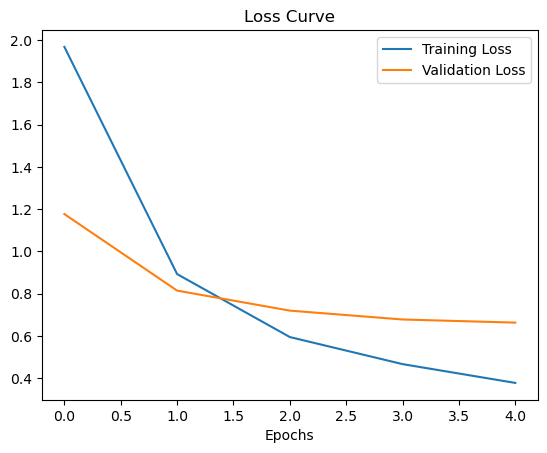

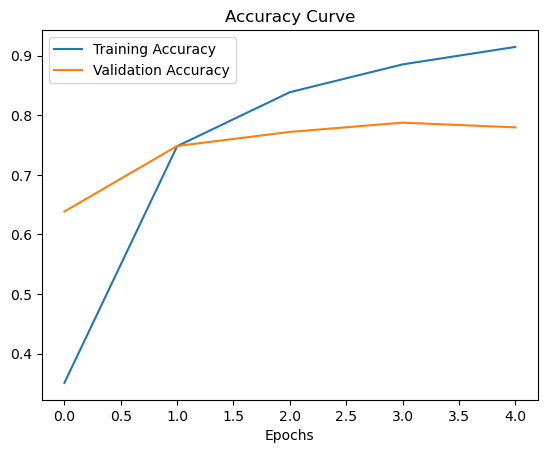

In [37]:
# Plotting Trainig and Validation Loss and Accuracy Curves:
plot_loss_curves(resnet_history)

You can see the power of TensorFlow Hub here. The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set `trainable=False`, these patterns remain frozen (non-trainable) during training.

This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.

Okay, we've trained a ResNetV250 model, time to do the same with EfficientNetB0 model.

## Creating and Testing EfficientNetB0 Feature Extraction Model:

In [38]:
# Create The Efficient Model:
efficientnet_model = create_model(model_url= efficientnet_url,
                                 num_classes= train_data_10_percent.num_classes)

In [39]:
# EfficientNet Model Summary:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [40]:
# Compiling EfficientNet Model:

efficientnet_model.compile(optimizer= Adam(),
                          loss= CategoricalCrossentropy(),
                          metrics= ["accuracy"])

In [41]:
# Fit The Model:

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                             validation_data= test_data,
                                             epochs= 5,
            callbacks= [create_tensorboard_callback(dir_name= "Tenserflow_Hub",
                            experiment_name= "EfficientNetB0")])

Saving TensorBoard Log Files to Tenserflow_Hub\EfficientNetB0\20240504-161333

Epoch 1/5
24/24 [==============================] - 35s 1s/step - loss: 1.9149 - accuracy: 0.3880 - val_loss: 1.3283 - val_accuracy: 0.7096
Epoch 2/5
24/24 [==============================] - 22s 928ms/step - loss: 1.0788 - accuracy: 0.7653 - val_loss: 0.8766 - val_accuracy: 0.8136
Epoch 3/5
24/24 [==============================] - 23s 970ms/step - loss: 0.7627 - accuracy: 0.8307 - val_loss: 0.7018 - val_accuracy: 0.8392
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.6075 - accuracy: 0.8640 - val_loss: 0.6126 - val_accuracy: 0.8564
Epoch 5/5
24/24 [==============================] - 23s 993ms/step - loss: 0.5145 - accuracy: 0.8880 - val_loss: 0.5587 - val_accuracy: 0.8660


The EfficientNetB0 model does even better than the ResNetV250 model! Achieving over 85% accuracy on the test set...again **with only 10% of the training data**.

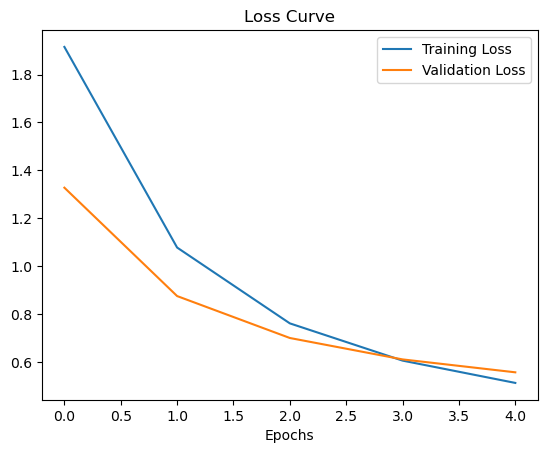

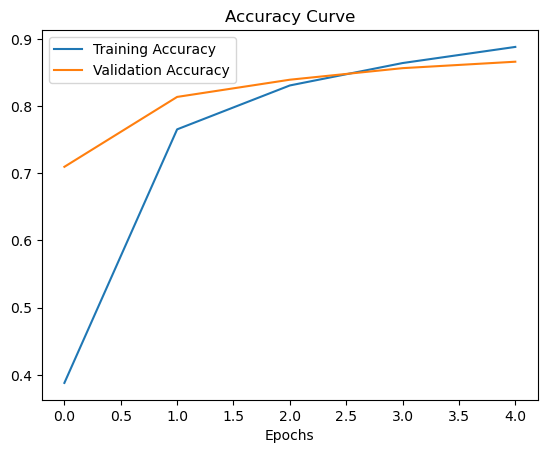

In [42]:
# Plotting Trainig and Validation Loss and Accuracy Curves:
plot_loss_curves(efficientnet_history)

## Comparing models using TensorBoard

In [47]:
!pip install tensorboard

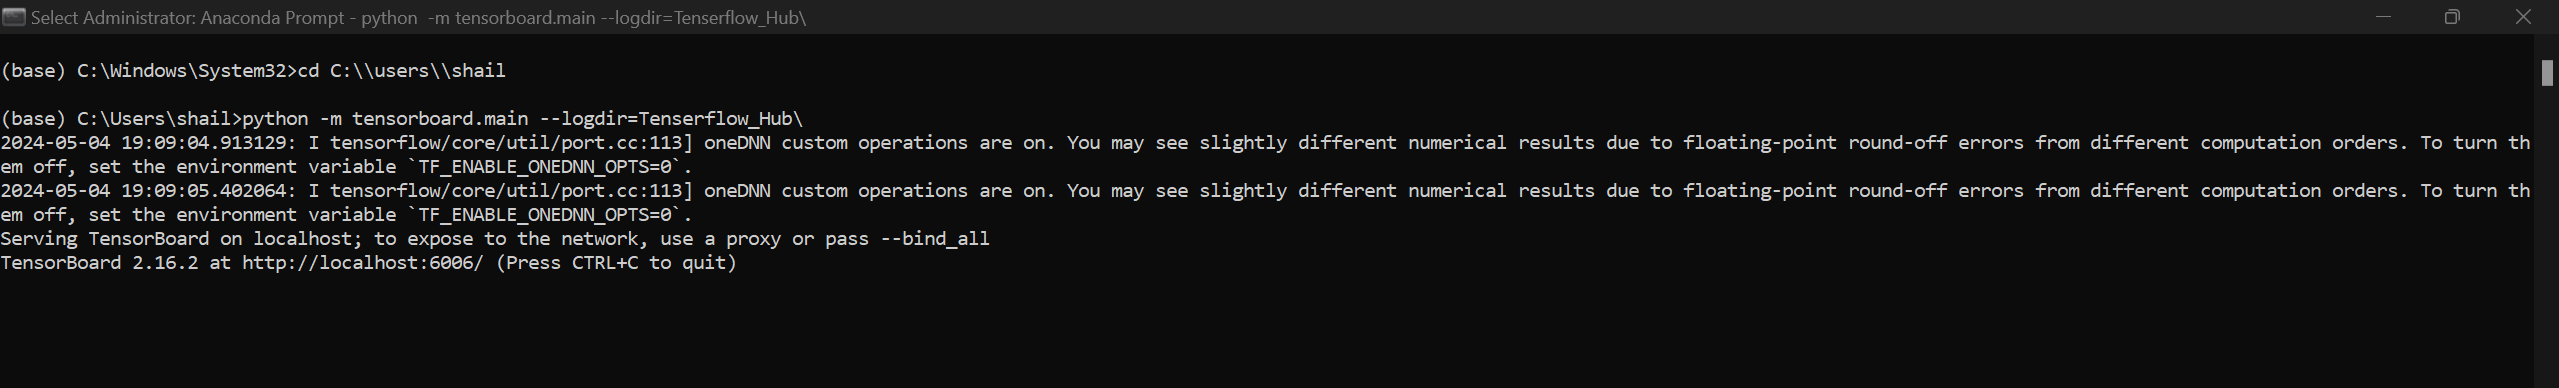

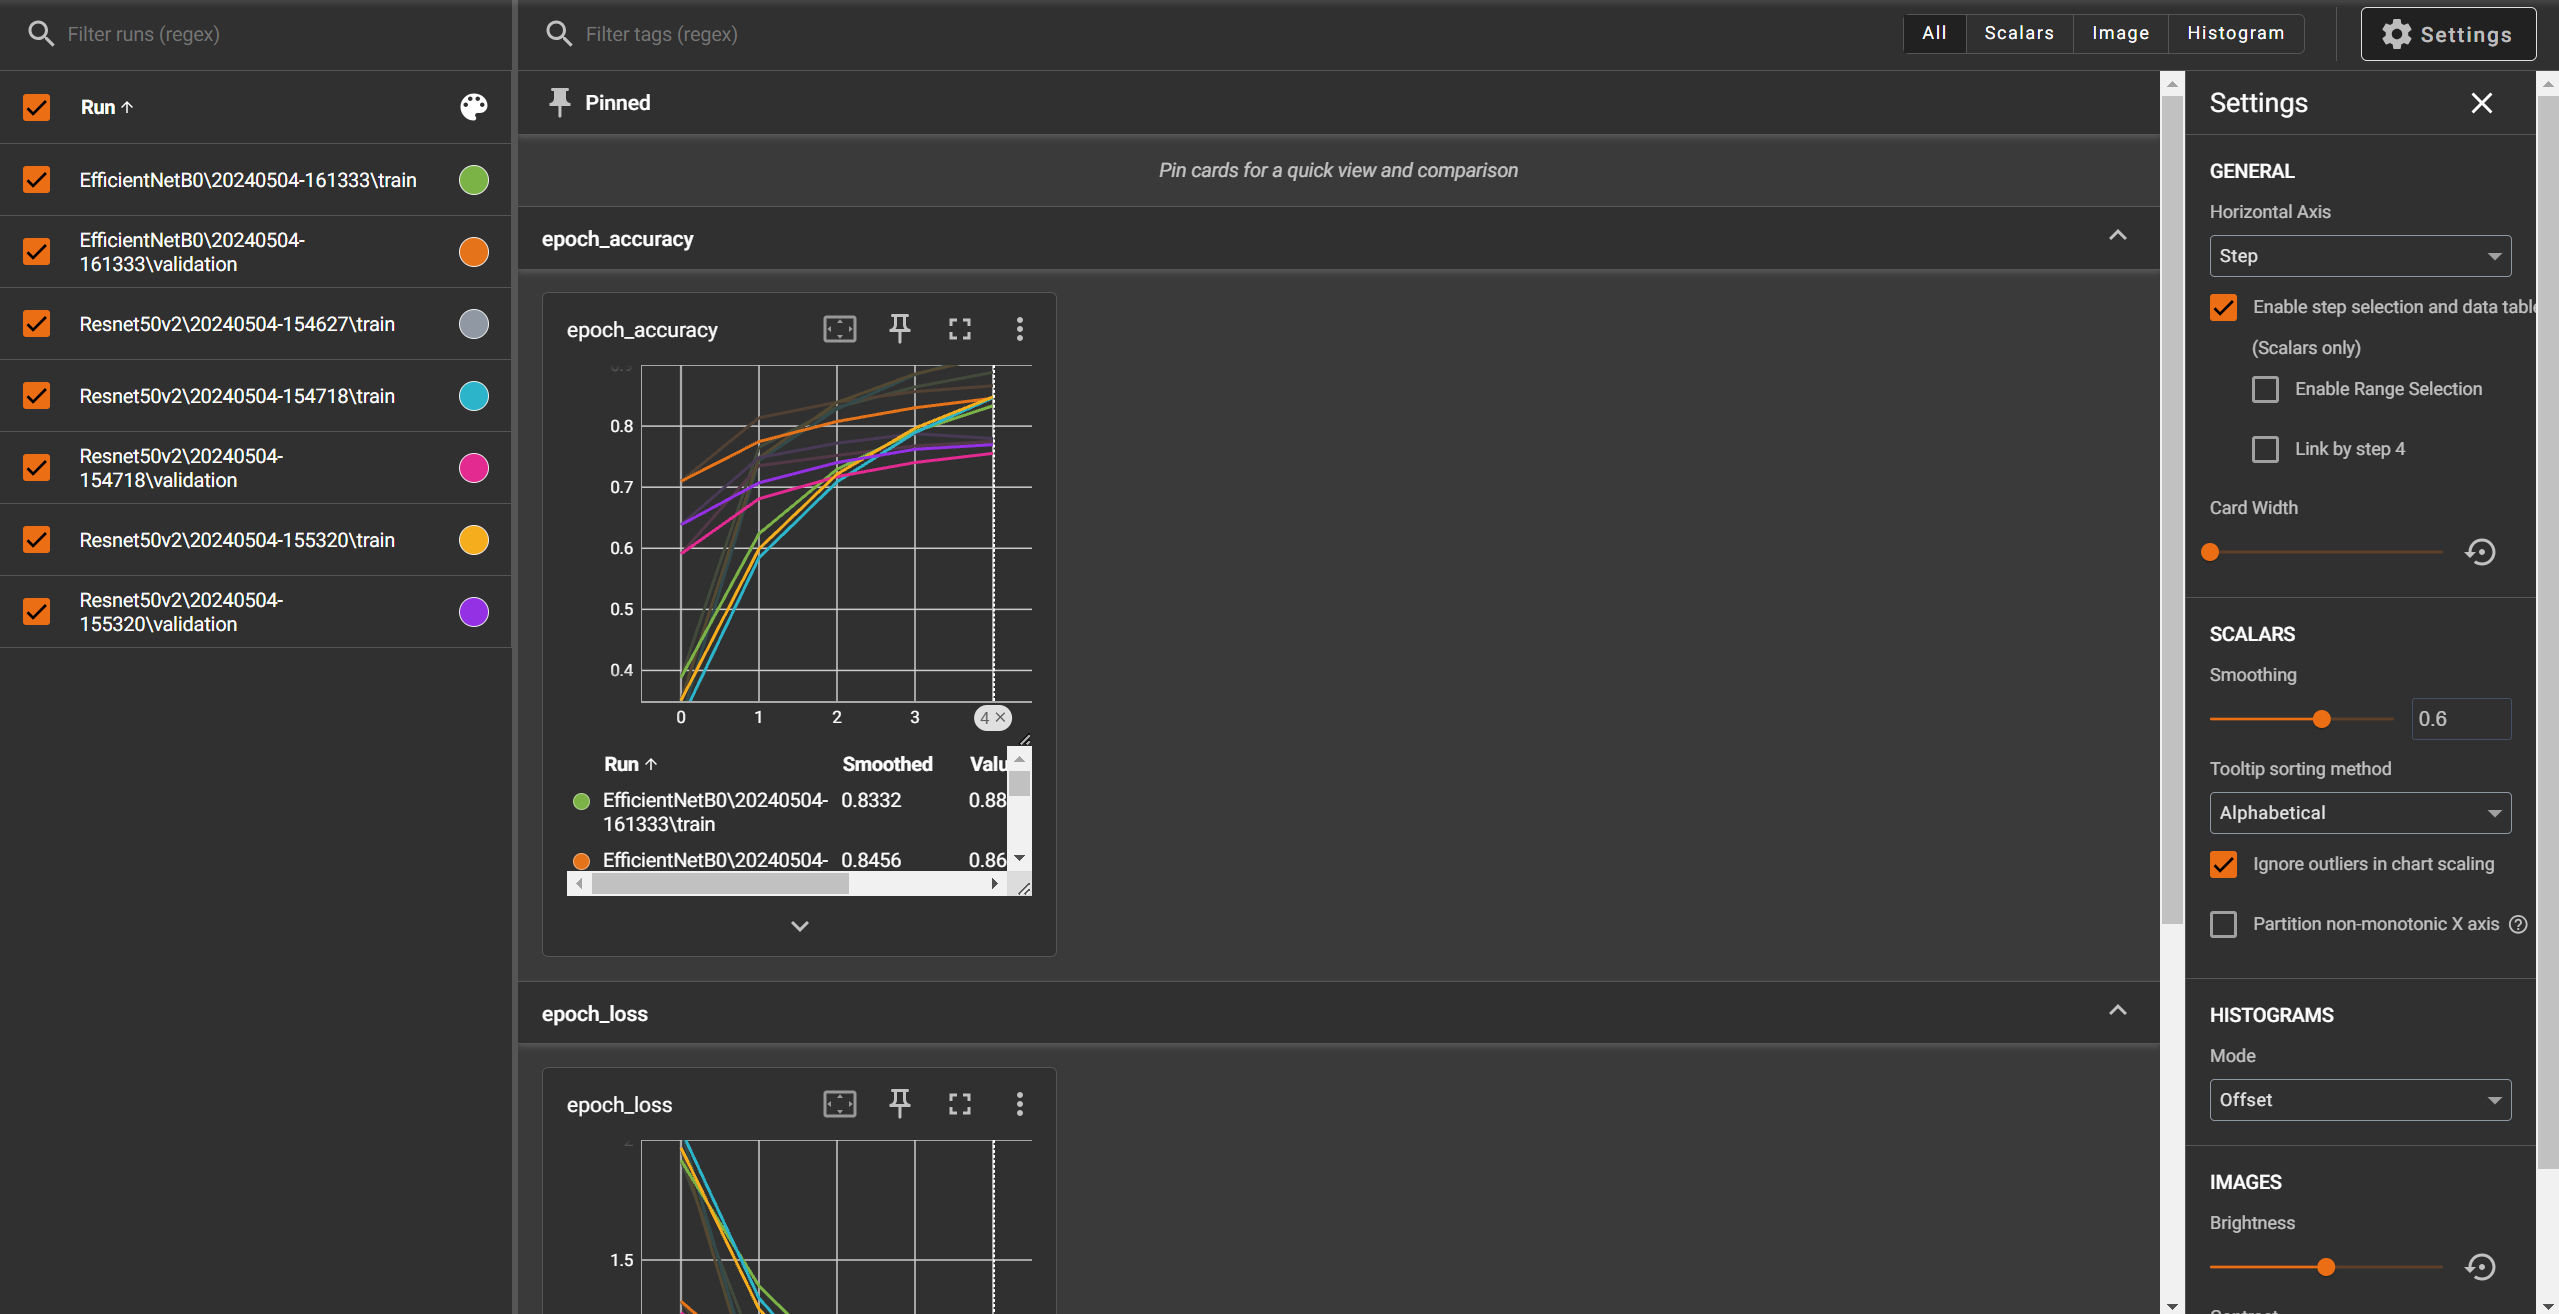